In [ ]:
# window range, skull masking 등 전처리 비교 시각화

In [6]:
import sys
sys.path.append("C:/Users/401-09/Desktop/Stroke")

In [7]:
import os
os.chdir("C:/Users/401-09/Desktop/Stroke")

In [8]:
import matplotlib.pyplot as plt
from pydicom import dcmread
import numpy as np
import cv2
import os
import torch
import nibabel as nib

from preprocessing.hu_utils import dicom_to_hu
from preprocessing.brain_mask import apply_brain_mask
from preprocessing.windowing import window_image, normalize_image
from preprocessing.utils import resize_image
from scripts.preprocess import preprocess_ct_with_mask, preprocess_nii_with_mask, save_preprocessed

In [ ]:
# dicom 파일

In [10]:
# 1. Load
dicom_path = "./data/raw/Bleeding/DICOM/10002.dcm"
mask_path = "./data/raw/Bleeding/PNG/10002.png"

ds = dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)
mask = cv2.imread(mask_path, 0) / 255.0  # mask는 PNG인 경우

In [11]:
# 2. Process 단계별 저장
hu = dicom_to_hu(ds)
stripped = apply_brain_mask(hu, mask)
windowed = window_image(stripped, -40, 100)
normalized = normalize_image(windowed, -40, 100)
resized = resize_image(normalized, (512, 512))

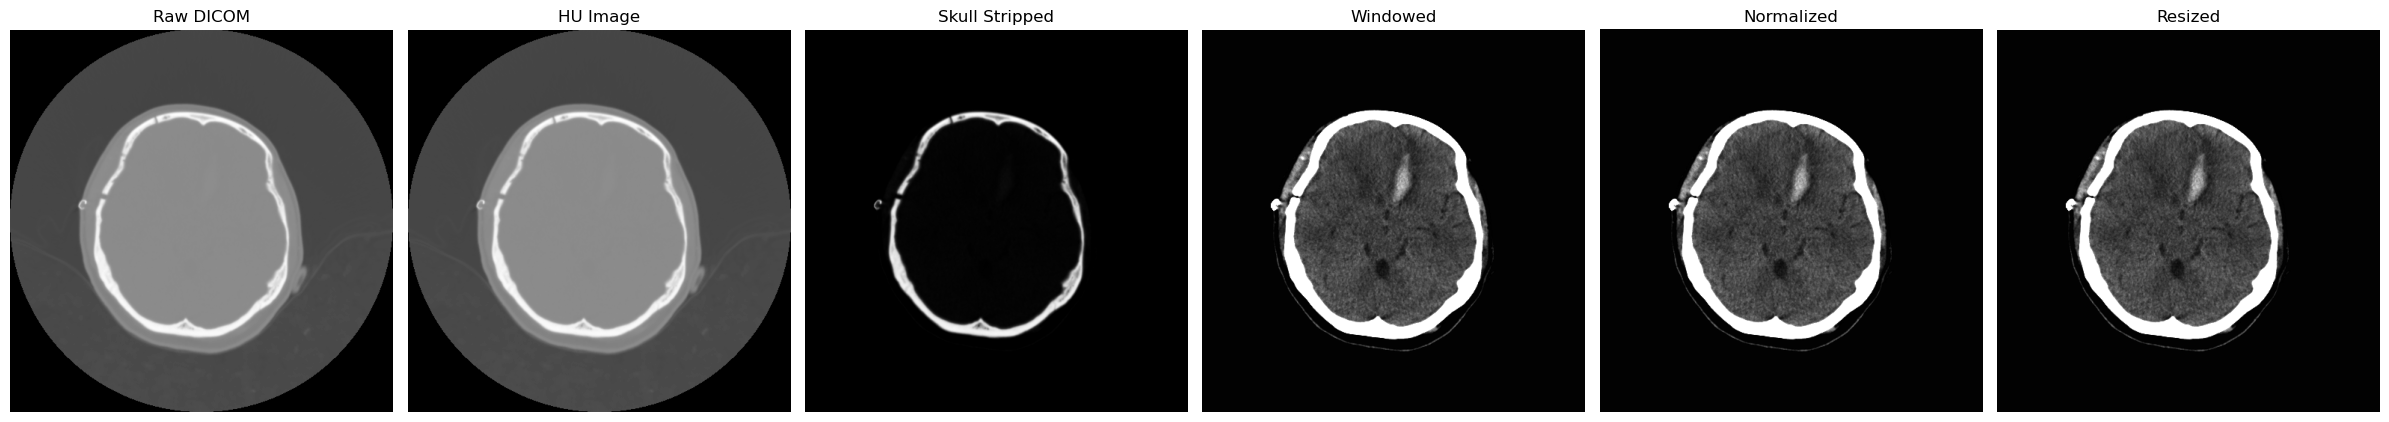

In [12]:
# 3. 시각화
fig, axs = plt.subplots(1, 6, figsize=(24, 5))
titles = ["Raw DICOM", "HU Image", "Skull Stripped", "Windowed", "Normalized", "Resized"]
images = [image, hu, stripped, windowed, normalized, resized]

for i in range(6):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 실제 실행(시각화 없이 바로 진행)
dicom_dir = "data/raw/Bleeding/DICOM"
mask_dir = "data/raw/Bleeding/PNG"
output_dir = "data/processed/train"

for filename in os.listdir(dicom_dir):
    if not filename.lower().endswith(".dcm"):
        continue

    case_id = os.path.splitext(filename)[0]
    dicom_path = os.path.join(dicom_dir, filename)
    mask_path = os.path.join(mask_dir, f"{case_id}.png")
    save_path = os.path.join(output_dir, f"{case_id}.pt")

    if not os.path.exists(mask_path):
        print(f"마스크 없음: {case_id}")
        continue

    try:
        ds = dcmread(dicom_path)
        mask = cv2.imread(mask_path, 0) / 255.0

        assert ds.pixel_array.shape == mask.shape, f"Shape mismatch: {case_id}"

        image = preprocess_ct_with_mask(ds, mask)
        save_preprocessed(image, save_path)

        print(f"저장 완료: {case_id}")

    except Exception as e:
        print(f"오류 발생: {case_id} | {e}")

In [ ]:
# 저장 확인 (pt는 전처리된 CT 이미지(마스크 정보 없음))
tensor = torch.load("data/processed/train/sample.pt")
print(tensor.shape, tensor.dtype)  # → torch.Size([1, 512, 512]) torch.float32

# nii 파일

In [9]:
# ================================
# 파일 로드
# ================================
volume_path = "./data/raw/Bleeding/ct_scans/049.nii.gz"
brain_mask_path = "./data/raw/Bleeding/brain_masks/049_bet.nii.gz"

volume_nii = nib.load(volume_path)
mask_nii = nib.load(brain_mask_path)

volume = volume_nii.get_fdata()
brain_mask = mask_nii.get_fdata()

print("Volume shape:", volume.shape)
print("Brain mask shape:", brain_mask.shape)

Volume shape: (512, 512, 39)
Brain mask shape: (512, 512, 39)


In [10]:
# ================================
# 전처리 단계별 저장
# ================================
# hu_image = dicom_to_hu(volume) => dicom 은 hu 처리가 필요하지만 nii는 hu 자체라 필요없음
hu_image = volume.copy()
stripped_image = apply_brain_mask(hu_image, brain_mask)
windowed_image = window_image(stripped_image, -40, 100)
normalized_image = normalize_image(windowed_image, -40, 100)
resized_image = resize_image(normalized_image, (512, 512))

In [11]:
def visualize_images(volume, brain_mask, hu_image, stripped_image, windowed_image, normalized_image, resized_image):
    mid_idx = volume.shape[2] // 2

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 4, 1)
    plt.title("Raw DICOM")
    plt.imshow(volume[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 2)
    plt.title("Brain Mask")
    plt.imshow(brain_mask[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 3)
    plt.title("Skull Stripped")
    plt.imshow(stripped_image[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 4)
    plt.title("Windowed")
    plt.imshow(windowed_image[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 5)
    plt.title("Normalized")
    plt.imshow(normalized_image[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 6)
    plt.title("Resized")

    if resized_image.ndim == 3:
        plt.imshow(resized_image[0], cmap="gray")
    else:
        plt.imshow(resized_image, cmap="gray")

    plt.tight_layout()
    plt.show()

In [12]:
visualize_images(volume, brain_mask, hu_image, stripped_image, windowed_image, normalized_image, resized_image)

: 

In [ ]:
# ================================
# 전체 슬라이스 전처리 & 저장 
# ================================
def process_directory(nii_dir, mask_dir, brain_mask_dir, output_dir):
    for fname in os.listdir(nii_dir):
        if not fname.lower().endswith(('.nii', '.nii.gz')):
            continue  # NIfTI 파일만 처리

        case_id = os.path.splitext(fname)[0]
        nii_path = os.path.join(nii_dir, fname)  # NIfTI 파일 경로
        mask_path = os.path.join(mask_dir, f"{case_id}.png")  # 병변 마스크
        brain_mask_path = os.path.join(brain_mask_dir, f"{case_id}.nii.gz")  # 뇌 마스크
        
        # 병변 마스크 및 뇌 마스크 파일 존재 확인
        if not os.path.exists(mask_path):
            print(f"병변 마스크 없음: {case_id}")
            continue
        if not os.path.exists(brain_mask_path):
            print(f"뇌 마스크 없음: {case_id}")
            continue
        
        try:
            # NIfTI 파일 읽기
            nii_data = nib.load(nii_path)
            volume = nii_data.get_fdata()

            # 병변 마스크 읽기
            mask = cv2.imread(mask_path, 0) / 255.0  # 병변 마스크를 0-1 범위로 읽기

            # 뇌 마스크 읽기
            brain_mask_nii = nib.load(brain_mask_path)
            brain_mask = brain_mask_nii.get_fdata()

            # 이미지 크기 일치 확인
            assert volume.shape == mask.shape, f"Shape mismatch: {case_id}"
            assert volume.shape == brain_mask.shape, f"Brain mask shape mismatch: {case_id}"

            # 전처리
            image = preprocess_nii_with_mask(volume, brain_mask)

            # 저장 경로 설정
            save_path = os.path.join(output_dir, f"{case_id}.pt")
            save_preprocessed(image, save_path)

            print(f"저장 완료: {case_id}")

        except Exception as e:
            print(f"오류 발생: {case_id} | {e}")  # 오류 메시지 출력


In [ ]:
nii_dir = "data/raw/Bleeding/NIfTI"  # NIfTI 파일이 저장된 폴더 경로
mask_dir = "data/raw/Bleeding/PNG"  # 병변 마스크 파일 경로
brain_mask_dir = "data/raw/Bleeding/Brain_Masks"  # 뇌 마스크 파일 경로
output_dir = "data/processed/train"  # 전처리된 결과 저장 경로

process_directory(nii_dir, mask_dir, brain_mask_dir, output_dir)

In [ ]:
# 저장 확인 (pt는 전처리된 CT 이미지(마스크 정보 없음))
tensor = torch.load("data/processed/train/sample.pt")
print(tensor.shape, tensor.dtype)  # → torch.Size([1, 512, 512]) torch.float32